In [29]:
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *

data = {
    0.25: load_data('../stats/fpm_6_x0.25.json'),
    0.5: load_data('../stats/fpm_6_x0.5.json'),
    1: load_data('../stats/fpm_6_x1.json'),
    2: load_data('../stats/fpm_6_x2.json'),
    # 3: load_data('../stats/fpm_6_x3.json'),
    # 'x16': load_data('../stats/fpm_5_2D_x4.json'),
    # 'x25': load_data('../stats/fpm_4_2D_x5.json')
    # 'x64': load_data('../stats/fpm_4_2D_x8.json'),
}

In [30]:
shape = [3, 2]
figsize = (12, 6)

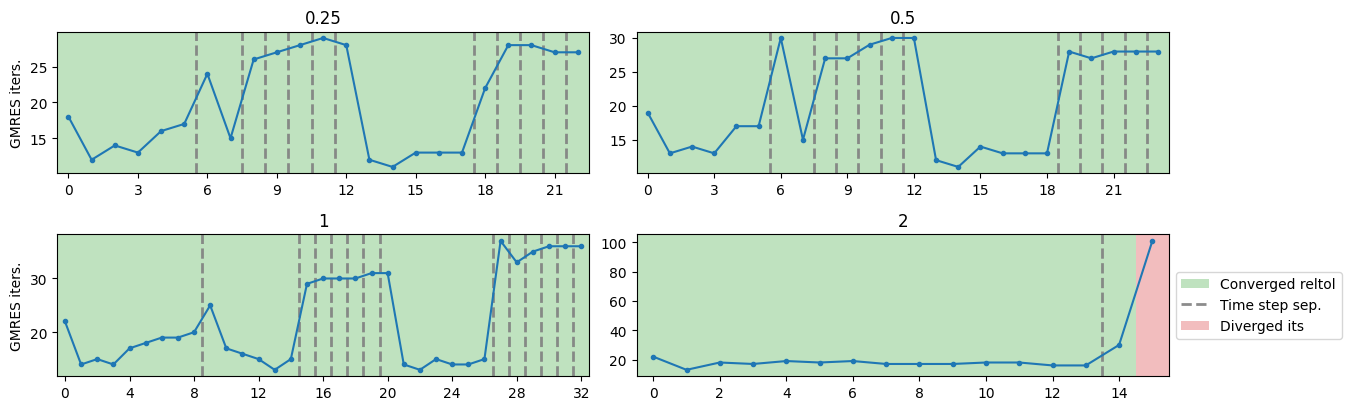

In [31]:
def render_element(entry: Sequence[TimeStepStats]):
    color_converged_reason(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

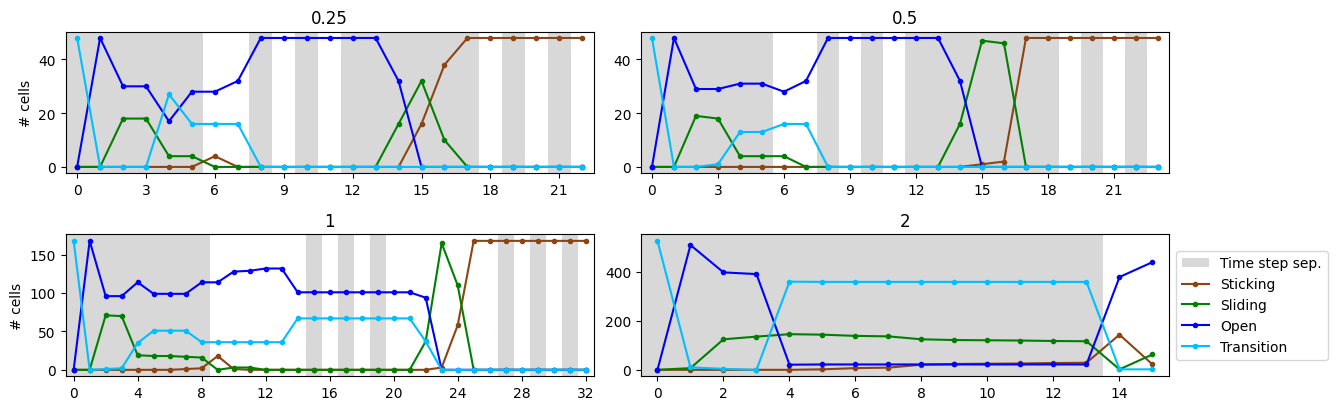

In [32]:
plot_grid(data, plot_sticking_sliding_open_transition, shape=shape, figsize=figsize, ylabel='# cells')

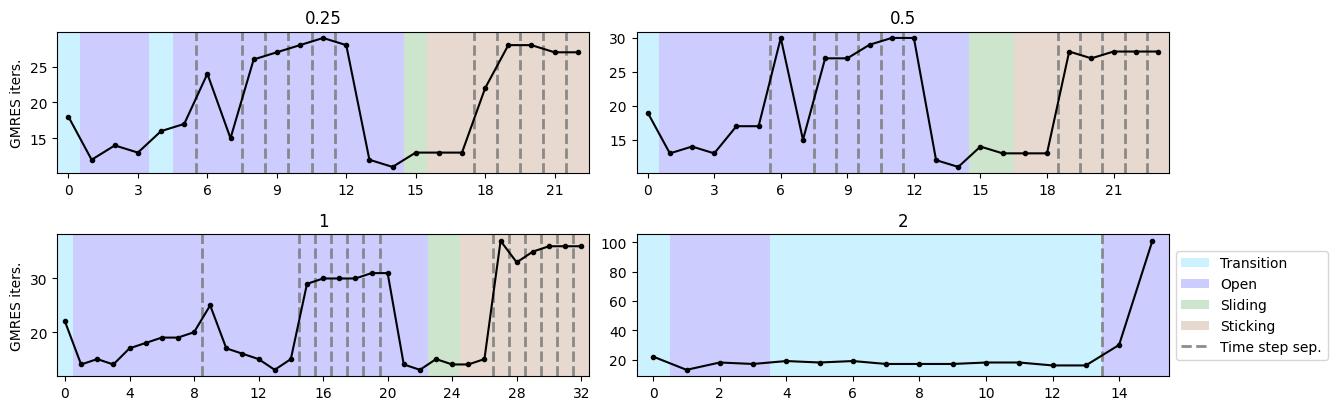

In [33]:
def render_element(entry: Sequence[TimeStepStats]):
    color_sticking_sliding_open_transition(entry)
    color_time_steps(entry, fill=False, legend=True)
    plt.gca().grid(False)
    plt.plot(get_gmres_iterations(entry), marker='.', color='black')

plot_grid(data, render_element, shape=shape, figsize=figsize, legend=True)

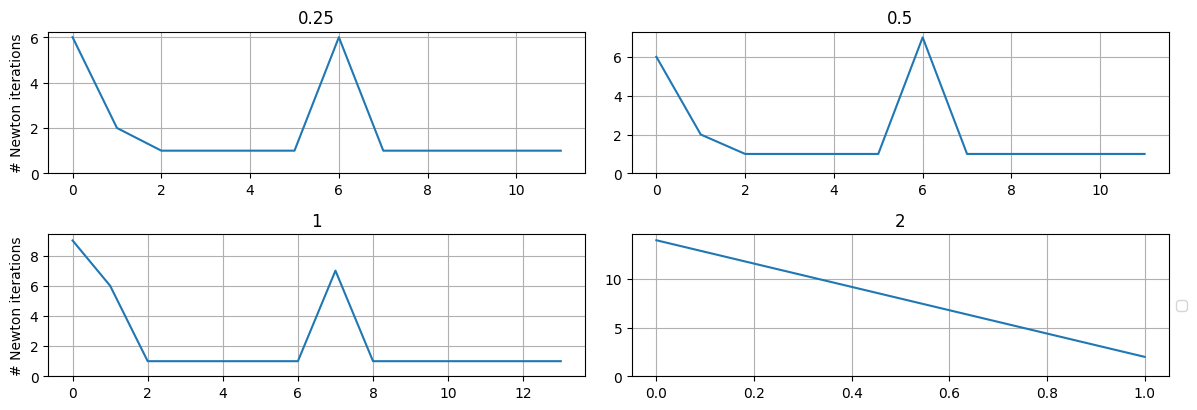

In [34]:
def render_element(entry: Sequence[TimeStepStats]):
    plt.plot(get_newton_iterations(entry))
    plt.ylim(bottom=0)
    plt.grid()

plot_grid(data, render_element, shape=shape, figsize=figsize, ylabel='# Newton iterations', xlabel='time step')

# Testing bad matrix

In [35]:
assert False

AssertionError: 

In [ ]:
from fpm_6 import make_model

cell_size_multiplier = 0.25
model = make_model(cell_size_multiplier)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model._initialize_solver()

cell_size_multiplier = 0.25


num sticking: 0
num sliding: 0
num open: 0
num trans: 48


In [ ]:
mat_idx = 15
entry = data[cell_size_multiplier]
print(get_gmres_iterations(entry)[mat_idx])
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(entry, mat_idx)

5


In [ ]:
model.linear_system = mat, rhs
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.equation_system.set_variable_values(state, time_step_index=0)  # 1
model.ad_time_step.set_value(dt)
st, sl, op, tr = model.sticking_sliding_open_transition()
print(sum(st))
print(sum(sl))
print(sum(op))
print(sum(tr))

# model.assemble_linear_system()


16
32
0
0


/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.06
True residual decrease: 8.936407809267278e-07


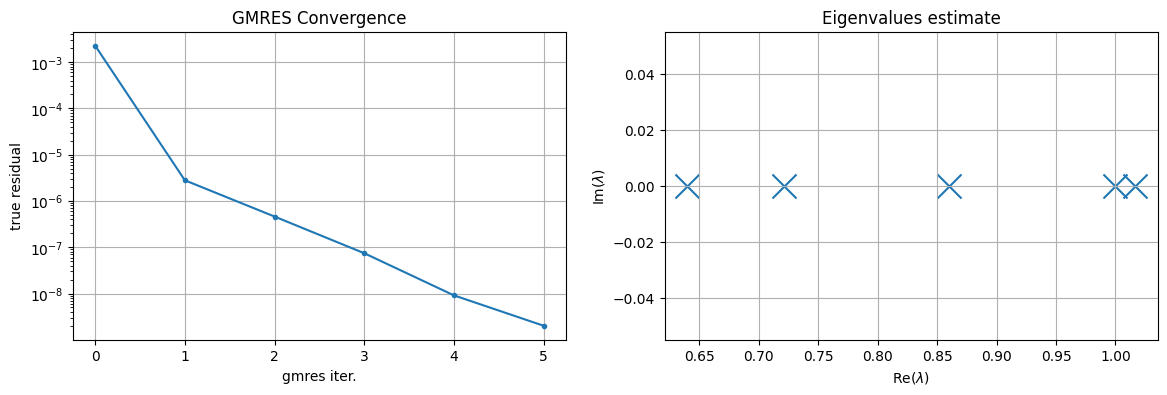

In [ ]:
sol = None
perm_mat, prec_orig = model._prepare_solver()
J = perm_mat[:]
solve_petsc(perm_mat.mat, prec_orig, rhs=model.rhs_Q, pc_side='right', tol=1e-6)

Returning only Schur complement based on [1, 5]
Solve  took: 0.06
True residual decrease: 2.6797218446069964e-11


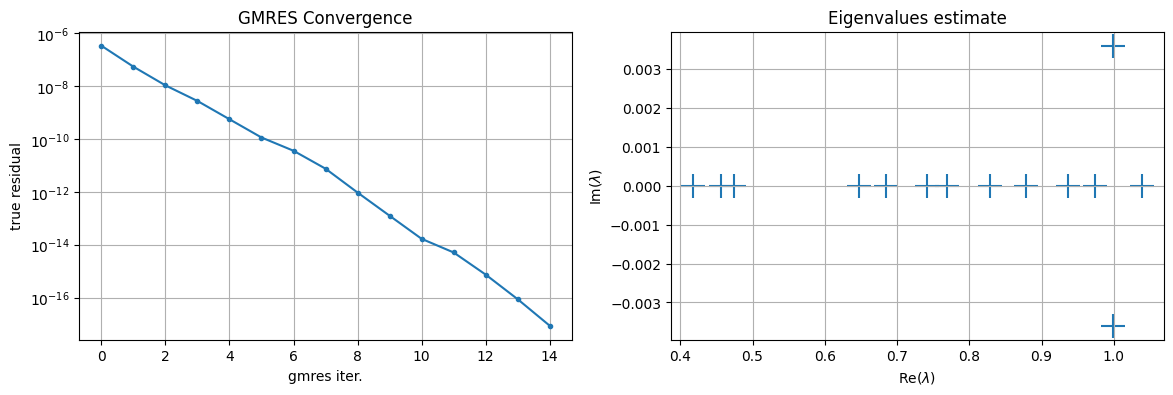

In [ ]:
from block_matrix import SolveSchema, make_solver
from mat_utils import *
from preconditioner_mech import make_J44_inv_bdiag
from fixed_stress import make_fs, get_fixed_stress_stabilization, make_local_stab_15, make_fs_experimental

schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    only_complement=True,
    complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
            groups=[1, 5],
            solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
            # invertor=lambda bmat: model._fixed_stress.mat,
            invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
            # invertor=lambda bmat: make_fs(model, bmat).mat,

            # invertor=lambda bmat: get_fixed_stress_stabilization(model),
            # invertor=lambda bmat: make_local_stab_15(bmat=perm_mat, base=2, nd=1),
            invertor_type="physical",
            # complement=SolveSchema(
            #     groups=[0, 2],
            #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
            # ),
        # ),
    ),
)

rhs_Q_global = model.Q_perm.global_rhs(model.rhs_Q)
bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=perm_mat)
# preconditioner.pc.view()

solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs_Q_global), pc_side='right', tol=1e-10, logx_eigs=False)

Matrix 0 - make_fs produces zeros in [2, 2]. And performs better than make_fs_experimental. Make_fs_experimental has negative eigenvalue (?)

Matrix 1 - model._fixed_stress diverged. make_fs - nonzeros in [2, 2], Converged in 120 iters. Bad eigs spectrum

Matrix 21 (bad) - make_fs_experimental solves 29 iters, bad eigs. make_fs - worse spectrum, 50 iters

In [ ]:
def solve_petsc(
    mat: BlockMatrixStorage,
    solve_schema: SolveSchema = None,
    rhs_global=None,
    rhs=None,
    label="",
    logx_eigs=False,
    normalize_residual=False,
    tol=1e-10,
    pc_side: Literal["left", "right"] = "left",
    return_solution: bool = False,
    ksp_view: bool = False,
    rhs_eq_groups: Sequence[np.ndarray] = None,
    Qleft: BlockMatrixStorage = None,
    Qright: BlockMatrixStorage = None,
):
    from block_matrix import make_solver

    if rhs is not None:
        assert False, "Pass rhs_global instead"

    mat_Q = mat.copy()
    if Qleft is not None:
        assert Qleft.active_groups == mat.active_groups
        mat_Q.mat = Qleft.mat @ mat.mat
    if Qright is not None:
        assert Qright.active_groups == mat.active_groups
        mat_Q.mat = mat.mat @ Qright.mat

    mat_permuted, prec = make_solver(solve_schema, mat_Q)

    if rhs_global is None:
        rhs_local = np.ones(mat.shape[0])
    else:
        rhs_local = mat_permuted.local_rhs(rhs_global)

    rhs_Q = rhs_local.copy()
    if Qleft is not None:
        Qleft = Qleft[mat_permuted.active_groups]
        rhs_Q = Qleft.mat @ rhs_Q

    gmres = PetscGMRES(
        mat_permuted, pc=prec, tol=tol, pc_side=pc_side, rhs_group_dofs=rhs_eq_groups
    )

    if ksp_view:
        gmres.ksp.view()

    t0 = time.time()
    sol_Q = gmres.solve(rhs_Q)
    print("Solve", label, "took:", round(time.time() - t0, 2))
    residuals = gmres.get_residuals()
    info = gmres.ksp.getConvergedReason()
    eigs = gmres.ksp.computeEigenvalues()

    print(
        "True residual permuted:", norm(mat_permuted.mat @ sol_Q - rhs_Q) / norm(rhs_Q)
    )

    if Qright is not None:
        Qright = Qright[mat_permuted.active_groups]
        sol = mat.local_rhs(Qright.global_rhs(Qright.mat @ sol_Q))
        print(
            "True residual:",
            norm(mat.mat @ sol - mat.local_rhs(rhs_global))
            / norm(mat.local_rhs(rhs_global)),
        )
    else:
        sol = sol_Q

    print("PETSc Converged Reason:", info)
    linestyle = "-"
    if info <= 0:
        linestyle = "--"
        if len(eigs) > 0:
            print("lambda min:", min(abs(eigs)))

    plt.gcf().set_size_inches(14, 4)

    # ax = plt.gca()
    ax = plt.subplot(1, 2, 1)
    if normalize_residual:
        residuals /= residuals[0]
    ax.plot(residuals, label=label, marker=".", linestyle=linestyle)
    ax.set_yscale("log")

    ksp_norm_type = gmres.options.getString("ksp_norm_type", "default")
    if ksp_norm_type == "unpreconditioned":
        ax.set_ylabel("true residual")
    else:
        ax.set_ylabel("preconditioned residual")
    ax.set_xlabel("gmres iter.")
    ax.grid(True)
    if label != "":
        ax.legend()
    ax.set_title("GMRES Convergence")

    ax = plt.subplot(1, 2, 2)
    if logx_eigs:
        eigs.real = abs(eigs.real)
    # ax.scatter(eigs.real, eigs.imag, label=label, marker="$\lambda$", alpha=0.9)
    ax.scatter(eigs.real, eigs.imag, label=label, alpha=1, s=300, marker=next(MARKERS))
    ax.set_xlabel(r"Re($\lambda)$")
    ax.set_ylabel(r"Im($\lambda$)")
    ax.grid(True)
    if label != "":
        ax.legend()
    if logx_eigs:
        plt.xscale("log")
    ax.set_title("Eigenvalues estimate")
    if return_solution:
        return sol_Q

Returning only Schur complement based on [1, 5]
Solve  took: 0.06
True residual decrease: 2.6797218446069964e-11


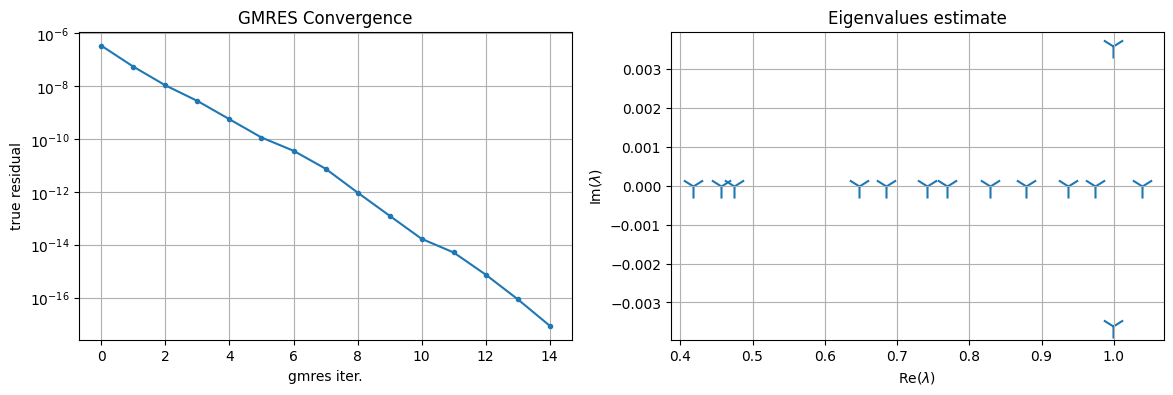

In [ ]:
def S44_experimental(bmat):
    J_44_inv = inv_block_diag(mat=bmat[[4]].mat, nd=model.nd)
    Stab = J[[1, 5]].empty_container()
    Stab.mat = J[[1, 5], 4].mat @ J_44_inv @ J[4, [1, 5]].mat
    # Stab[5, 1] = 0
    return -Stab.mat


schema = SolveSchema(
    groups=[4],
    solve=lambda bmat: inv_block_diag(mat=bmat[[4]].mat, nd=model.nd),
    invertor=S44_experimental,
    invertor_type="physical",
    only_complement=True,
    complement=SolveSchema(
        # groups=[3],
        # solve=lambda bmat: PetscILU(bmat[[3]].mat),
        # invertor=lambda bmat: extract_diag_inv(bmat[[3]].mat),
        # complement=SolveSchema(
        groups=[1, 5],
        solve=lambda bmat: PetscAMGMechanics(mat=bmat[[1, 5]].mat, dim=model.nd),
        # invertor=lambda bmat: model._fixed_stress.mat,
        invertor=lambda bmat: make_fs_experimental(model, bmat).mat,
        # invertor=lambda bmat: make_fs(model, bmat).mat,
        # invertor=lambda bmat: get_fixed_stress_stabilization(model),
        # invertor=lambda bmat: make_local_stab_15(bmat=perm_mat, base=2, nd=1),
        invertor_type="physical",
        # complement=SolveSchema(
        #     groups=[0, 2],
        #     solve=lambda bmat: PetscAMGFlow(mat=bmat[[0, 2]].mat),
        # ),
        # ),
    ),
)

rhs_Q_global = model.Q_perm.global_rhs(model.rhs_Q)
bmat_reordered, preconditioner = make_solver(schema=schema, mat_orig=perm_mat)
# preconditioner.pc.view()

solve_petsc(
    bmat_reordered.mat,
    preconditioner,
    rhs=bmat_reordered.local_rhs(rhs_Q_global),
    pc_side="right",
    tol=1e-10,
    logx_eigs=False,
)

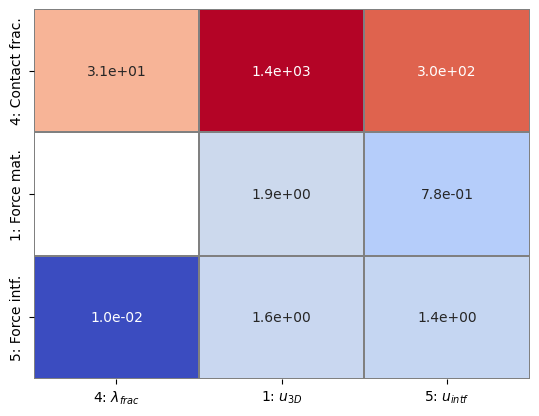

In [ ]:
J[[4,1,5]].plot_max()

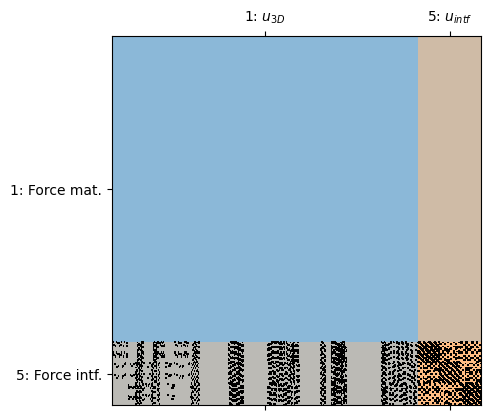

In [ ]:
J_44_inv = inv_block_diag(mat=J[[4]].mat, nd=model.nd)
Stab = J[[1,5]].empty_container()
Stab.mat = J[[1,5], 4].mat @ J_44_inv @ J[4, [1,5]].mat

# Stab.plot_max()
Stab.color_spy()
# Stab[[5,5]]

Solve  took: 0.06
True residual decrease: 2.6797218446069964e-11


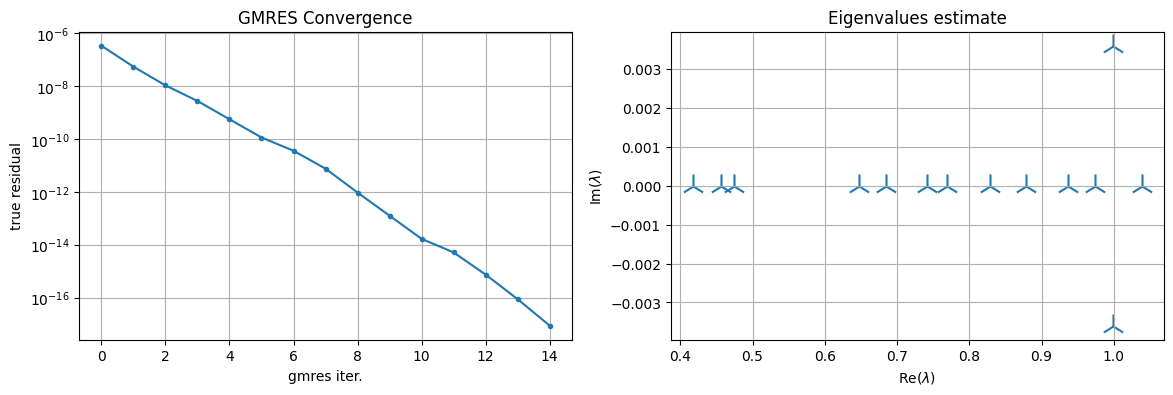

In [ ]:
solve_petsc(bmat_reordered.mat, preconditioner, rhs=bmat_reordered.local_rhs(rhs_Q_global), pc_side='right', tol=1e-10, logx_eigs=False)

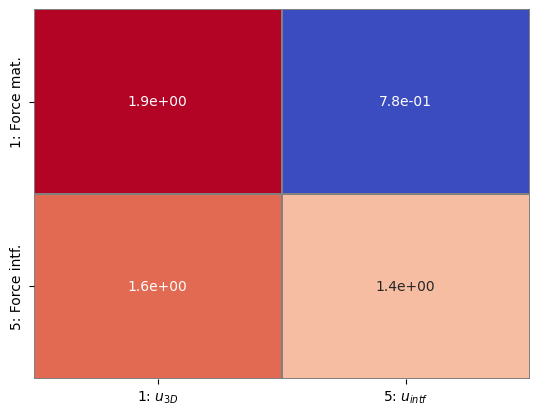

In [ ]:
J[[1,5]].plot_max()